In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import netket as nk

import sys
# sys.path.append('/scratch/samiz/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/Vscore_ThermodynamicLimit_Analysis/AFM_VMC')


import jax.numpy as jnp
import matplotlib.pyplot as plt

import flax.linen as nn
from typing import Any
from netket.jax import logsumexp_cplx

from Afm_Model_functions import *
from vmc_2spins_sampler import *
from Spin_Observables import *
import pickle
import ViT_2d_Vers5 as vit
from data_extracter import *
import os
from jax import vmap



In [4]:
L = 8

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,4,5,6,7,
                   16,17,18,19,20,21,22,23,
                   32,33,34,35,36,37,38,39,
                   48,49,50,51,52,53,54,55]
}

Ha64, hi2d = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True,
                        parity=0., sublattice = None, make_rotation=False, exchange_XY=False)

Ha64_SS = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=False,
                        parity=0., sublattice = pHa['sublattice'], make_rotation=True, exchange_XY=True)


print('the Hilbert space is: ', hi2d)
XX = Exchange_OP(hi2d, TriGraph)

sa_Ha = nk.sampler.MetropolisHamiltonian(hilbert=hi2d, hamiltonian=XX, n_chains=32, sweep_size = 3* hi2d.size)
sa_ex = nk.sampler.MetropolisExchange(hilbert=hi2d, graph=TriGraph, n_chains=32, sweep_size=3*hi2d.size)

rules5050 = nk.sampler.rules.MultipleRules(rules = [sa_Ha.rule, sa_ex.rule], probabilities = [0.5, 0.5])
sa_HaEx5050 = nk.sampler.MetropolisSampler(hi2d, rules5050, n_chains=32, sweep_size=3*hi2d.size)


def Sz_tot(graph, hilbert):
    """
    input:
    graph: (netket.graph) the graph of the system
    hilbert: (netket.hilbert) the hilbert space of the system

    return:
    the total Sz operator
    """
    Sz = 0.0
    Ntot = graph.n_nodes
    for i in range(Ntot):
        Sz += sigmaz(hilbert, i)
    return Sz/Ntot

Mtot = Sz_tot(nk.graph.Triangular(extent=[L,L], pbc=True), hi2d)


the Hilbert space is:  Spin(s=1/2, N=64, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7efd3841c410>)


In [5]:
def get_tanslation(Lx, Ly, Ntot, px, py):
    """
    function to all translation of the lattice where tranlsation in y-direction is done by 2 sites
    px, py are the sizes of the patch 

    return: translations of whole lattice restricted to patch
    """

    assert Ntot == Lx * Ly, "The number of lattice nodes must be equal to the product of the number of lattice sites in x and y direction."

    nodes = jnp.arange(0, Ntot)
    transl = []

    for i in range(px):
        for j in range(0,py, 2):
            transl.append(jnp.roll(nodes.reshape(-1, Ly), shift=j, axis=1).reshape(-1)) #translations in y direction jnp.roll(nodes, shift=, axis=0)
        
        nodes = jnp.roll(nodes, shift=Ly, axis=0) #translations in x direction

    transl = jnp.array(transl)
    assert transl.shape[0] == px * py / 2

    return transl

In [6]:
pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 4,
    'Cy': 4,
    'patch_arr': HashableArray(jnp.array([[0,1,2,3,8,9,10,11,16,17,18,19,24,25,26,27],
                                          [4,5,6,7,12,13,14,15,20,21,22,23,28,29,30,31],
                                          [32,33,34,35,40,41,42,43,48,49,50,51,56,57,58,59],
                                          [36,37,38,39,44,45,46,47,52,53,54,55,60,61,62,63]])),
    }

pVit['transls'] = HashableArray(get_tanslation(L, L, L**2, 4, 4))



m_Vit44 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)

pVit['Cx'] = 2; pVit['Cy'] = 2
pVit['patch_arr'] = HashableArray(jnp.array([[0,1,8,9], [2,3,10,11], [4,5,12,13], [6,7,14,15],
                                           [16,17,24,25], [18,19,26,27], [20,21,28,29], [22,23,30,31], 
                                             [32,33,40,41], [34,35,42,43], [36,37,44,45], [38,39,46,47],
                                             [48,49,56,57], [50,51,58,59], [52,53,60,61], [54,55,62,63]]))

pVit['transls'] = HashableArray(get_tanslation(L, L, L**2, 2, 2)) 

m_Vit22 = vit.Vit_2d_full_symm(patch_arr=(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'],
                                recover_full_transl_symm=True, translations=pVit['transls'], recover_spin_flip_symm=True)


In [8]:
# import the good parameters:


vit_44 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit44, n_samples=2**12, n_discard_per_chain=16)

with open('patching_xy44/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    vit_44.variables = pickle.load(f)

vit_44_sign = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit44, n_samples=2**12, n_discard_per_chain=16)
with open('patching_xy44_signstructure/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    vit_44_sign.variables = pickle.load(f)

vit_22 = nk.vqs.MCState(sampler=sa_HaEx5050, model=m_Vit22, n_samples=2**12, n_discard_per_chain=16)

with open('patching_xy22/Log_Files/log_vit_sampler_HaEx_5050_transflip.pickle', 'rb') as f:
    vit_22.variables = pickle.load(f)

In [9]:
class rbm_trans_flip(nn.Module):
    translations: jnp.ndarray
    alpha : float
    param_dtype: Any = jnp.dtype

    @nn.compact
    def __call__(self, x):
        rbm = nk.models.RBM(alpha=self.alpha, param_dtype=self.param_dtype)

        x = jnp.apply_along_axis(lambda elt: jnp.array([rbm(x[...,elt]), rbm(-x[...,elt])]), axis = -1, arr =jnp.asarray(self.translations))
        x = x.reshape(-1,x.shape[-1])
        return logsumexp_cplx(x, axis = 0)

In [10]:
rbm_transls = get_tanslation(L,L,L**2, L,L)
rbm1 = rbm_trans_flip(translations=HashableArray(rbm_transls), alpha=1.0, param_dtype=complex)

vs_rbm1_SS = nk.vqs.MCState(sampler=sa_HaEx5050, model=rbm1, n_samples=2**12, n_discard_per_chain=16)
with open('8x8_XYZ_RBM/Log_Files/log_saHaEx5050_rbm_alpha1.0_transflip_SS.pickle', 'rb') as f:
    vs_rbm1_SS.variables = pickle.load(f)

In [9]:
# vit_44.expect(Ha64)

In [11]:
data = {}
path_vit22 = 'patching_xy22/Log_Files'
path_vit44 = 'patching_xy44/Log_Files'
path_vit44_sign = 'patching_xy44_signstructure/Log_Files'
path_rbm = '8x8_XYZ_RBM/Log_Files'
paths = [path_vit22, path_vit44, path_vit44_sign, path_rbm]
names = ['vit22', 'vit44', 'vit44_sign', ' ']
for j, path in enumerate(paths):
    logs = [f for f in os.listdir(path) if '.log' in f]
    if path==path_rbm:
        extract_data(logs, data, path, ['log_saHaEx5050_'], [names[j]], L=8)
    else:
        extract_data(logs, data, path, ['log_vit_sampler_HaEx_5050'], [names[j]], L=8)
    


In [11]:
data.keys()

dict_keys(['vit22', 'vit22_transflip', 'vit44', 'vit44_transflip', 'vit44_trans', 'vit44_sign', 'vit44_sign_transflip', 'vit44_sign_trans_old', ' rbm_alpha1.0', ' rbm_alpha1.0_SS', ' rbm_alpha1.0_transflip_SS'])

/tmp/ipykernel_1216065/2758164114.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


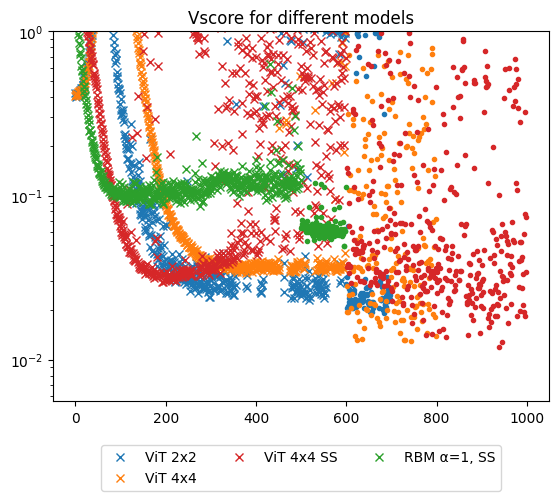

In [12]:
plt.figure()
plt.title('Vscore for different models')

step1 = len(data['vit22']['Vscore'])
plt.semilogy(data['vit22']['Vscore'], marker='x', linestyle='', label='ViT 2x2', color='tab:blue')
step2 = len(data['vit22_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit22_transflip']['Vscore'], marker='.', linestyle='', color='tab:blue')

step1 = len(data['vit44']['Vscore'])
plt.semilogy(data['vit44']['Vscore'], marker='x', linestyle='', label='ViT 4x4', color='tab:orange')
step2 = len(data['vit44_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit44_transflip']['Vscore'], marker='.', linestyle='', color='tab:orange')

step1 = len(data['vit44_sign']['Vscore'])
plt.semilogy(data['vit44_sign']['Vscore'], marker='x', linestyle='', label='ViT 4x4 SS', color='tab:red')
step2 = len(data['vit44_sign_transflip']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data['vit44_sign_transflip']['Vscore'], marker='.', linestyle='', color='tab:red')

step1 = len(data[' rbm_alpha1.0_SS']['Vscore'])
plt.semilogy(data[' rbm_alpha1.0_SS']['Vscore'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data[' rbm_alpha1.0_transflip_SS']['Vscore'])
plt.semilogy(step1 + jnp.arange(0, step2), data[' rbm_alpha1.0_transflip_SS']['Vscore'], marker='.', linestyle='', color='tab:green')



plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

plt.ylim(0,1)
plt.show()



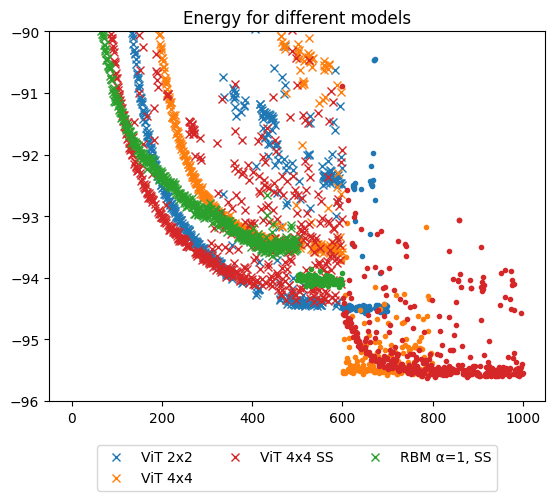

In [13]:
plt.figure()
plt.title('Energy for different models')

step1 = len(data['vit22']['Energy'])
plt.plot(data['vit22']['Energy'], marker='x', linestyle='', label='ViT 2x2', color='tab:blue')
step2 = len(data['vit22_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit22_transflip']['Energy'], marker='.', linestyle='', color='tab:blue')

step1 = len(data['vit44']['Energy'])
plt.plot(data['vit44']['Energy'], marker='x', linestyle='', label='ViT 4x4', color='tab:orange')
step2 = len(data['vit44_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit44_transflip']['Energy'], marker='.', linestyle='', color='tab:orange')

step1 = len(data['vit44_sign']['Energy'])
plt.plot(data['vit44_sign']['Energy'], marker='x', linestyle='', label='ViT 4x4 SS', color='tab:red')
step2 = len(data['vit44_sign_transflip']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data['vit44_sign_transflip']['Energy'], marker='.', linestyle='', color='tab:red')

step1 = len(data[' rbm_alpha1.0_SS']['Energy'])
plt.plot(data[' rbm_alpha1.0_SS']['Energy'], marker='x', linestyle='', label='RBM α=1, SS', color='tab:green')
step2 = len(data[' rbm_alpha1.0_transflip_SS']['Energy'])
plt.plot(step1 + jnp.arange(0, step2), data[' rbm_alpha1.0_transflip_SS']['Energy'], marker='.', linestyle='', color='tab:green')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.ylim(-96, -90)
plt.show()


In [14]:
print(data['vit22_transflip']['Energy'][-1], data['vit22_transflip']['Variance'][-1], data['vit22_transflip']['Vscore'][-1])
print(data[' rbm_alpha1.0_transflip_SS']['Energy'][-1], data[' rbm_alpha1.0_transflip_SS']['Variance'][-1], data[' rbm_alpha1.0_transflip_SS']['Vscore'][-1])

print(data['vit44_sign_transflip']['Energy'][-1], data['vit44_sign_transflip']['Variance'][-1], data['vit44_sign_transflip']['Vscore'][-1])

print(data['vit44_transflip']['Energy'][-1], data['vit44_transflip']['Variance'][-1],  data['vit44_transflip']['Vscore'][-1])


-94.53223697683256 3.772206558285407 0.027015087686946385
-93.91358550269321 15.489532761627725 0.11239634777270137
-95.54301692702678 4.872271992316777 0.034158949488900525
-95.54202890661995 1.979159153047636 0.01387594861177827


In [15]:
64 * 1.97 / (-95.543016927)**2

0.013811736958111734

#### Magnetization

In [16]:
print(vs_rbm1_SS.expect(Mtot))
print(vit_22.expect(Mtot))
print(vit_44.expect(Mtot))
print(vit_44_sign.expect(Mtot))

0.00037+0.00000j ± 0.00061 [σ²=0.00127, R̂=1.0037]
-0.0021+0.0000j ± 0.0015 [σ²=0.0019, R̂=1.0241]
0.00052+0.00000j ± 0.00069 [σ²=0.00102, R̂=1.0087]
-0.004+0.000j ± 0.012 [σ²=0.015, R̂=1.1890]


In [14]:
SpinSpin_Corrs = {}
SpinSpin_Corrs_Err = {}

def compute_spin_spin_corr(vs, label, make_rotate=False, sublattice=None):
    values = []
    errors = []
    for j in range(1, hi2d.size):
        op = SpinSpin(0, j, hi2d, make_rotation=make_rotate, sublattice=sublattice).to_jax_operator() / 3
        stats = vs.expect(op)
        values.append(stats.mean)
        errors.append(stats.error_of_mean)
    SpinSpin_Corrs[label] = values
    SpinSpin_Corrs_Err[label] = errors

compute_spin_spin_corr(vit_22, 'vit22', make_rotate=False)
compute_spin_spin_corr(vit_44, 'vit44', make_rotate=False)
compute_spin_spin_corr(vit_44_sign, 'vit44_sign', make_rotate=True, sublattice=pHa['sublattice'])
compute_spin_spin_corr(vs_rbm1_SS, ' rbm_alpha1.0_SS', make_rotate=True, sublattice=pHa['sublattice'])

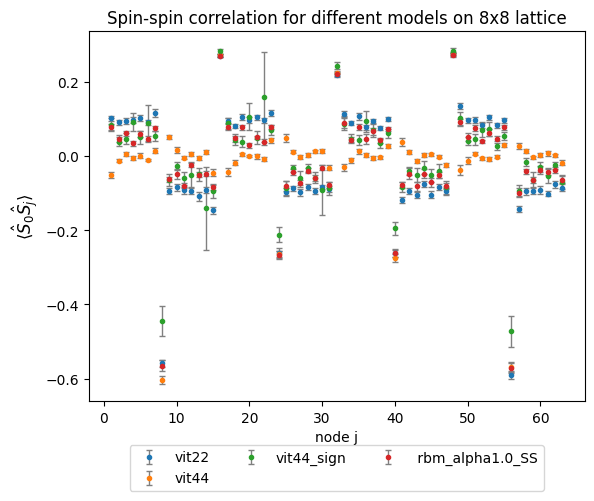

In [31]:
plt.figure()
plt.title('Spin-spin correlation for different models on 8x8 lattice')
plt.ylabel(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$', fontsize=12)
plt.xlabel('node j')
for key in SpinSpin_Corrs.keys():
    # plt.plot(np.arange(1,64), np.real(SpinSpin_Corrs[key]), marker='.', linestyle='', label=key)
    plt.errorbar(x=np.arange(1,64), y=np.real(SpinSpin_Corrs[key]), yerr=SpinSpin_Corrs_Err[key],  fmt='.', linestyle='', label=key,  ecolor='gray', elinewidth=1, capsize=2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
plt.show()

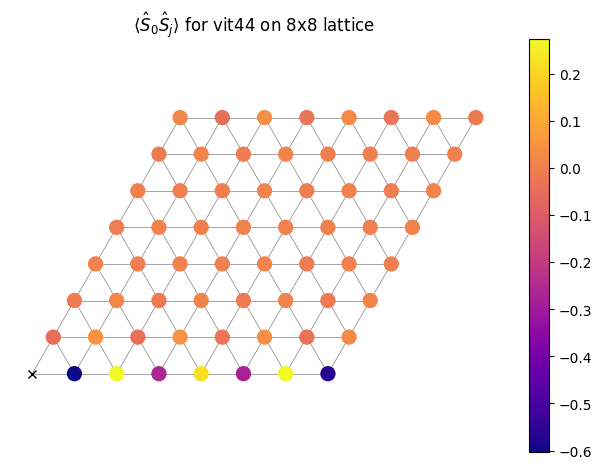

In [35]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit44 on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit44']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()


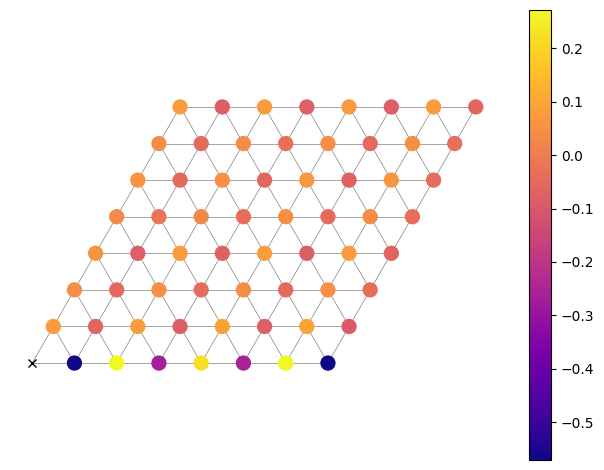

In [21]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs[' rbm_alpha1.0_SS']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()


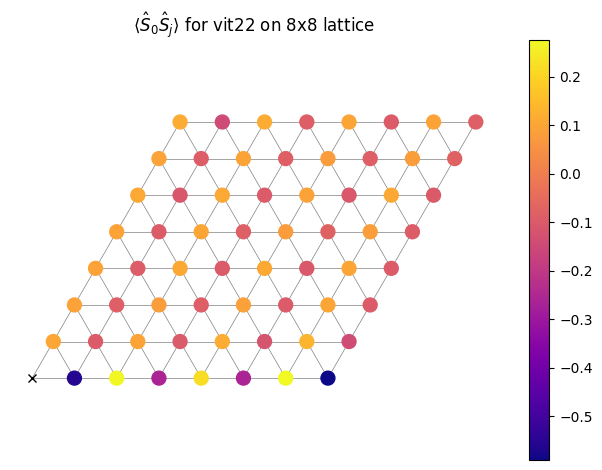

In [42]:
tri_open = nk.graph.Triangular(extent=[L, L], pbc=False)

xcoords = TriGraph.positions[:, 0]
ycoords = TriGraph.positions[:, 1]

plt.figure()
plt.title(r'$\langle \hat{{S}}_0 \hat{S}_j \rangle$ for vit22 on 8x8 lattice')
plt.xlabel('x-direction')
plt.ylabel('y-direction')
plt.axis('equal')
plt.axis('off')  # Remove the coordinate frame
for edge in tri_open.edges():
    start, end = tri_open._positions[edge[0]], tri_open._positions[edge[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], color='black', linewidth=0.5, alpha=0.5, zorder=1)

plt.plot(xcoords[0], ycoords[0], marker='x', color='black')
plt.scatter(x=xcoords[1:], y=ycoords[1:], c=np.real(SpinSpin_Corrs['vit22']), cmap='plasma', s=100, label=' α=1')
plt.colorbar()
plt.tight_layout()

plt.show()

In [26]:
pi = np.pi
nodes = [
    (-4*pi/3, 0),  # Leftmost node
    (-2*pi/3, -2*pi/np.sqrt(3)),  # Bottom left
    (2*pi/3, -2*pi/np.sqrt(3)),  # Bottom right
    (4*pi/3, 0),  # Rightmost node
    (2*pi/3, 2*pi/np.sqrt(3)),  # Top right
    (-2*pi/3, 2*pi/np.sqrt(3)),  # Top left
    (-4*pi/3, 0)  # Close the hexagon by repeating the first node
]

x_coords, y_coords = zip(*nodes)

In [20]:
ds = Create_Differences(TriGraph)
sss, ss_err = Create_SpinSpin_Vec(vit_44,hi2d, TriGraph, get_error=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44, Sk_vit_err= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, sss, hi2d.size, ss_err)

In [21]:
with open('StructureFactor_vit44.pickle', 'wb') as f:
    pickle.dump((Sk_vit44, Sk_vit_err), f)
with open('StructureFactor_vit44_errors.pickle', 'wb') as f:
    pickle.dump((Sk_vit_err), f)

In [37]:
# position = np.where((np.isclose(ks[:, 0], 3.14)) & (np.isclose(ks[:, 1], 0.0)))
# position = position = np.where((np.isclose(ks[:, 0], 3.14)) )
np.where(np.all(np.isclose(ks , (3.14159, 0.0)), axis=1))
# print(position)

(array([189]),)

In [38]:
Sk_vit44[189]

Array(11.36905874+0.00064518j, dtype=complex128)

In [53]:
with open('StructureFactor_vit44.pickle', 'rb') as f:
    Sk_vit44, Sk_vit_err = pickle.load(f)
# with open('StructureFactor_vit44_errors.pickle', 'rb') as f:
#     Sk_vit_err=pickle.load(f)

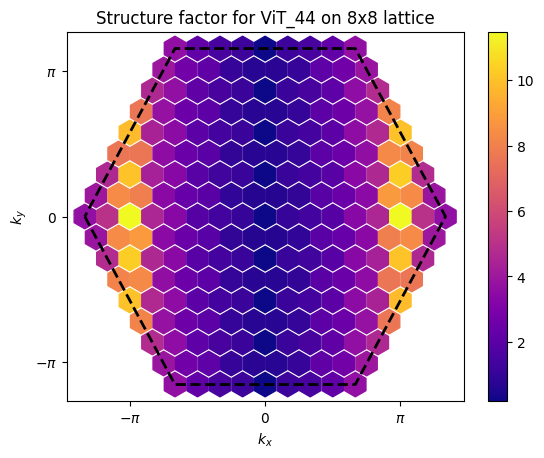

In [57]:
thickness = 20000 / L**2 
plt.title(r'Structure factor for ViT_44 on 8x8 lattice')
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=np.real(Sk_vit44), s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
ds = Create_Differences(TriGraph)

ss_44_SS, ss_err_SS_44 = Create_SpinSpin_Vec(vit_44_sign ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'])
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit44_SS, Sk_vit_err_SS= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_44_SS, hi2d.size, ss_err_SS_44)



In [24]:
# with open('StructureFactor_vit44_SS.pickle', 'wb') as f:
#     pickle.dump((Sk_vit44_SS, Sk_vit_err_SS), f)
# with open('StructureFactor_vit44_SS_errors.pickle', 'wb') as f:
#     pickle.dump((Sk_vit_err_SS), f)

with open('StructureFactor_vit44_SS.pickle', 'rb') as f:
    Sk_vit44_SS, Sk_vit_err_SS = pickle.load(f)
with open('StructureFactor_vit44_SS_errors.pickle', 'rb') as f:
    Sk_vit_err_SS = pickle.load(f)

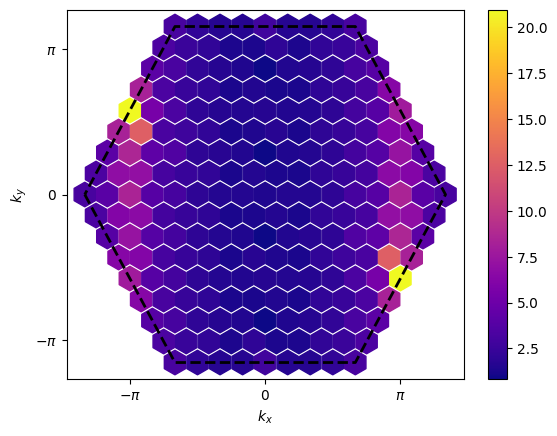

In [28]:
thickness = 20000 / L**2 
ks = FourierPoints_In_BrioullinZone(8, 100)

# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit44_SS.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
np.max(Sk_vit44_SS.real)

Array(20.96056738, dtype=float64)

In [29]:
ds = Create_Differences(TriGraph)

ss_rbm1, ss_err_rbm1 = Create_SpinSpin_Vec(vs_rbm1_SS ,hi2d, TriGraph, get_error=True, make_rotation=True, sublattice=pHa['sublattice'])
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_rbm1, Sk_vit_rbm1= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_rbm1, hi2d.size, ss_err_rbm1)


In [30]:
with open('StructureFactor_rbm1_SS.pickle', 'wb') as f:
    pickle.dump((Sk_rbm1, Sk_vit_rbm1), f)
with open('StructureFactor_rbm1_SS_errors.ipckle', 'wb') as f:
    pickle.dump((Sk_vit_rbm1), f)

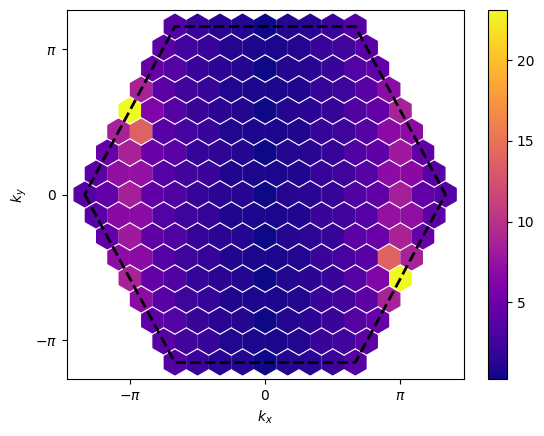

In [31]:
thickness = 20000 / L**2 
# im1 = axes[0].scatter(ks[:, 0], ks[:, 1], c=Sk_rbm1.real, cmap='plasma', s=thickness, marker='h')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_rbm1.real, s=thickness, cmap='plasma', marker='h')
# plt.imshow(Sk_vit22.reshape((dim, dim)).real.T, extent=[ks.min(), ks.max(), ks.min(), ks.max()], cmap='plasma')
# plt.plot(x_coords, y_coords, linestyle='-', color='black', linewidth=2, marker='o')
# Set ticks for x and y axes
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
ds = Create_Differences(TriGraph)
ss_22, ss_22_err = Create_SpinSpin_Vec(vit_22,hi2d, TriGraph, get_error=True)
# FourierPoints_In_BrioullinZone
ks = FourierPoints_In_BrioullinZone(8, 100)
Sk_vit22, Sk_vit22_err= vmap(Single_Struc_Fac, in_axes=(0, None, None, None, None))(((ks)), ds, ss_22, hi2d.size, ss_22_err)

In [33]:
with open('StructureFactor_vit22.pickle', 'wb') as f:
    pickle.dump((Sk_vit22, Sk_vit22_err), f)
with open('StructureFactor_vit22_errors.pickle', 'wb') as f:
    pickle.dump((Sk_vit22_err), f)

In [58]:
with open('StructureFactor_vit22.pickle', 'rb') as f:
    Sk_vit22, Sk_vit22_err = pickle.load(f)

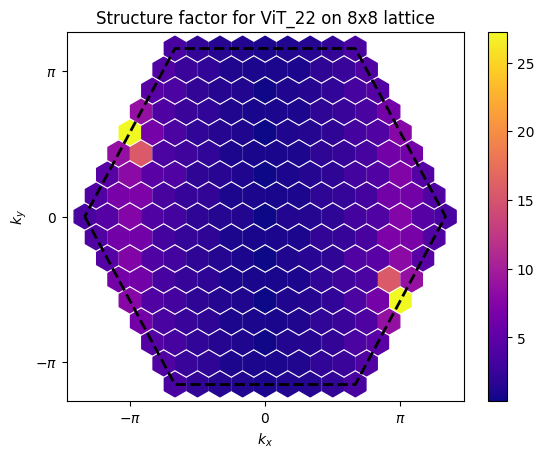

In [60]:
thickness = 20000 / L**2 
plt.title(r'Structure factor for ViT_22 on 8x8 lattice')
plt.plot(x_coords, y_coords, linestyle='--', color='black', linewidth=2)
plt.scatter(ks[:,0], ks[:,1], c=Sk_vit22.real, s=thickness, cmap='plasma', marker='h')
ticks = [-np.pi, 0, np.pi]
tick_labels = [r'$-\pi$', r'$0$', r'$\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks(ticks, tick_labels)
plt.xlabel(r'$k_x$')
plt.ylabel(r'$k_y$')
plt.colorbar()
# plt.savefig(fname='StructureFactor_8x8.png', dpi=300, bbox_inches='tight')
plt.show()